In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, StandardScaler

c:\MyFolder\Projects\JobCompetencies\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
df = pd.read_csv('../output/key_skill_frequency_all.csv')
df

,key_skill_name,key_skill_frequency
0,Linux,973
1,SQL,823
2,PostgreSQL,732
3,Docker,716
4,Git,701
...,...,...
4761,Тестирование 1C,1
4762,Построение системы пожарной безопасности с «0»,1
4763,Apollo,1
4764,Формирование бизнес-плана,1


In [30]:
key_skill_name_all = df['key_skill_name'].tolist()
key_skill_frequency_all = dict(zip(df['key_skill_name'], df['key_skill_frequency']))
print(key_skill_name_all)
print(key_skill_frequency_all)

['Linux', 'SQL', 'PostgreSQL', 'Docker', 'Git', 'Python', 'JavaScript', 'Kubernetes', 'TypeScript', 'CI/CD', 'Ansible', 'DevOps', 'React', 'Bash', 'Java', 'Управление проектами', 'Деловая коммуникация', 'REST API', 'HTML', 'Gitlab', 'PHP', 'Аналитическое мышление', 'QA', 'Организаторские навыки', 'Grafana', 'MySQL', 'API', 'Zabbix', 'Atlassian Jira', 'Английский язык', 'Тестирование', 'Деловая переписка', 'RabbitMQ', 'CSS', 'Redis', 'REST', 'Администрирование сетевого оборудования', 'Jenkins', 'Функциональное тестирование', 'Prometheus', 'Node.js', 'Nginx', 'Postman', 'Работа в команде', 'MS Excel', 'Администрирование серверов Linux', 'Управление командой', 'MS SQL', 'Ведение переговоров', 'Деловое общение', 'Работа с большим объемом информации', 'BPMN', 'Администрирование серверов Windows', 'Clickhouse', 'Apache Kafka', 'GitLab CI', 'Kafka', 'MongoDB', 'Анализ данных', 'Ручное тестирование', 'C#', 'TCP/IP', 'Настройка ПК', 'Заключение договоров', 'Системный анализ', 'Настройка сетевых

In [31]:
# Шаг 1: Ваши модели
models_names = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/all-MiniLM-L12-v2",
    "sentence-transformers/multi-qa-mpnet-base-dot-v1",
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1",
    "sentence-transformers/paraphrase-MiniLM-L6-v2"
]
similarity_threshold = 0.85

# Шаг 2: Загрузка моделей
models = [SentenceTransformer(model_name) for model_name in models_names]

# Шаг 3: Создание эмбеддингов
# Для каждой модели создаём эмбеддинги навыков
embeddings_by_model = [model.encode(key_skill_name_all, convert_to_tensor=False) for model in models]

# Шаг 4: Рассчёт итоговой матрицы сходства
# Считаем косинусное сходство для каждой модели
similarity_matrices = [cosine_similarity(embeddings) for embeddings in embeddings_by_model]

# Итоговая матрица сходства: берём максимум для каждой пары
final_similarity_matrix = np.maximum.reduce(similarity_matrices)

# Шаг 5: Кластеризация навыков
def cluster_skills_with_max_similarity(similarity_matrix, threshold):
    n = similarity_matrix.shape[0]
    clusters = []  # Список кластеров, каждый кластер — список индексов навыков
    
    for i in range(n):
        max_similarity = 0
        best_cluster = None
        
        for cluster in clusters:
            # Рассчитываем среднее сходство навыка i с навыками из текущего кластера
            cluster_indices = np.array(list(cluster))
            cluster_similarity = similarity_matrix[i, cluster_indices].mean()
            
            if cluster_similarity > max_similarity and cluster_similarity >= threshold:
                max_similarity = cluster_similarity
                best_cluster = cluster
        
        # Если нашли подходящий кластер, добавляем в него
        if best_cluster is not None:
            best_cluster.add(i)
        else:
            # Иначе создаём новый кластер
            clusters.append(set([i]))
    
    return clusters

# Получаем кластеры
clusters = cluster_skills_with_max_similarity(final_similarity_matrix, similarity_threshold)

# # Шаг 6: Преобразование индексов в навыки
clustered_skills = [[key_skill_name_all[i] for i in cluster] for cluster in clusters]

# Вывод результатов
for idx, cluster in enumerate(clustered_skills):
    print(f"Кластер {idx + 1}: {cluster}")

ImportError: 
 requires the protobuf library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/protocolbuffers/protobuf/tree/master/python#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [ ]:
# Построение словаря
# Для каждого кластера выбираем самый популярный элемент
skill_to_canonical = {}  # Итоговый словарь
for cluster in clusters:
    # Навыки в текущем кластере
    cluster_skills = [key_skill_name_all[i] for i in cluster]
    # Находим самый популярный навык в кластере
    most_popular_skill = max(cluster_skills, key=lambda skill: key_skill_frequency_all.get(skill, 0))
    # Добавляем в словарь: все навыки -> самый популярный
    for skill in cluster_skills:
        skill_to_canonical[skill] = most_popular_skill

# Вывод словаря
with open('../output/key_skill_all_to_canonical.json', 'w+', encoding='utf-8') as f:
    json.dump(skill_to_canonical, f)

# Пример использования словаря
# Предположим, есть DataFrame df с колонкой 'key_skill_name'
# df['key_skill_name'] = df['key_skill_name'].apply(lambda x: skill_to_canonical.get(x, x))


In [32]:
df = pd.read_csv('../output/everything.csv')
df

,professional_role_name,key_skill_name,vacancy_employer_name,vacancy_employer_trusted,vacancy_employer_it_accredited,vacancy_salary_from,vacancy_salary_to,vacancy_salary_currency,vacancy_salary_gross,vacancy_experience_from,vacancy_experience_to,vacancy_employment_name,vacancy_schedule_name,vacancy_search_text,vacancy_area
0,"Программист, разработчик",PostgreSQL,ИнфраМенеджер,t,f,NaN,NaN,NaN,NaN,1,3.0,Полная занятость,Удаленная работа,Backend-разработчик,Москва
1,"Программист, разработчик",C#,ИнфраМенеджер,t,f,NaN,NaN,NaN,NaN,1,3.0,Полная занятость,Удаленная работа,Backend-разработчик,Москва
2,"Программист, разработчик",.NET 6,ИнфраМенеджер,t,f,NaN,NaN,NaN,NaN,1,3.0,Полная занятость,Удаленная работа,Backend-разработчик,Москва
3,"Программист, разработчик",EF Core,ИнфраМенеджер,t,f,NaN,NaN,NaN,NaN,1,3.0,Полная занятость,Удаленная работа,Backend-разработчик,Москва
4,"Программист, разработчик",MS SQL,ИнфраМенеджер,t,f,NaN,NaN,NaN,NaN,1,3.0,Полная занятость,Удаленная работа,Backend-разработчик,Москва
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46274,Руководитель отдела продаж,3PL,Астрос Рус,t,f,NaN,NaN,NaN,NaN,6,NaN,Полная занятость,Полный день,Мобильный разработчик,Санкт-Петербург
46275,Руководитель отдела продаж,4PL,Астрос Рус,t,f,NaN,NaN,NaN,NaN,6,NaN,Полная занятость,Полный день,Мобильный разработчик,Санкт-Петербург
46276,Методолог,Запуск новых продуктов,Assistance Group,t,f,NaN,NaN,NaN,NaN,3,6.0,Полная занятость,Полный день,Мобильный разработчик,Санкт-Петербург
46277,Методолог,HR Business Strategy,Assistance Group,t,f,NaN,NaN,NaN,NaN,3,6.0,Полная занятость,Полный день,Мобильный разработчик,Санкт-Петербург


In [33]:
# Проверка наличия NaN в исходном DataFrame
print("Пропущенные значения до обработки:")
print(df.isnull().sum())

# Преобразование булевых значений
bool_columns = ['vacancy_employer_trusted', 'vacancy_employer_it_accredited', 'vacancy_salary_gross']

for bool_column in bool_columns:
    # Заполнение пропущенных значений перед обработкой
    df[bool_column].fillna('f', inplace=True)  # Предполагаем, что пропущенные значения означают 'f'
    # Преобразование 't' и 'f' в 1 и 0
    df[bool_column] = df[bool_column].map({'t': 1, 'f': 0})


# Проверка после обработки булевых колонок
print("Пропущенные значения после обработки булевых столбцов:")
print(df.isnull().sum())

# Указание столбцов с числовыми пропусками
numeric_columns = ["vacancy_salary_from", "vacancy_salary_to", "vacancy_experience_to"]

# Используем медиану для заполнения
imputer = SimpleImputer(strategy="median")
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

print("Пропущенные значения после обработки числовых колонок:")
print(df.isnull().sum())

# Преобразование категориальных данных
categorical_columns = [
    "professional_role_name", "key_skill_name", "vacancy_employer_name", 
    "vacancy_salary_currency", "vacancy_employment_name", 
    "vacancy_schedule_name", "vacancy_search_text", "vacancy_area"
]

for categorical_column in categorical_columns:
    # Заполнение пропусков модой
    df[categorical_column].fillna(df[categorical_column].mode()[0], inplace=True)

# Проверка после обработки категориальных колонок
print("Пропущенные значения после обработки категориальных столбцов:")
print(df.isnull().sum())

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Проверка пропусков в результирующем DataFrame
print("Пропущенные значения в df_encoded:")
print(df_encoded.isnull().sum())


Пропущенные значения до обработки:
professional_role_name                0
key_skill_name                        0
vacancy_employer_name                 0
vacancy_employer_trusted              0
vacancy_employer_it_accredited       44
vacancy_salary_from               29543
vacancy_salary_to                 34775
vacancy_salary_currency           27023
vacancy_salary_gross              27030
vacancy_experience_from               0
vacancy_experience_to              3200
vacancy_employment_name               0
vacancy_schedule_name                 0
vacancy_search_text                   0
vacancy_area                          0
dtype: int64
Пропущенные значения после обработки булевых столбцов:
professional_role_name                0
key_skill_name                        0
vacancy_employer_name                 0
vacancy_employer_trusted              0
vacancy_employer_it_accredited        0
vacancy_salary_from               29543
vacancy_salary_to                 34775
vacancy_salary_cu

C:\Users\Grisha\AppData\Local\Temp\ipykernel_21180\3653988450.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[bool_column].fillna('f', inplace=True)  # Предполагаем, что пропущенные значения означают 'f'
C:\Users\Grisha\AppData\Local\Temp\ipykernel_21180\3653988450.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

Пропущенные значения в df_encoded:
vacancy_employer_trusted          0
vacancy_employer_it_accredited    0
vacancy_salary_from               0
vacancy_salary_to                 0
vacancy_salary_gross              0
                                 ..
vacancy_area_Петергоф             0
vacancy_area_Рязань               0
vacancy_area_Санкт-Петербург      0
vacancy_area_Сочи                 0
vacancy_area_Тюмень               0
Length: 9084, dtype: int64


In [34]:
df_encoded

,vacancy_employer_trusted,vacancy_employer_it_accredited,vacancy_salary_from,vacancy_salary_to,vacancy_salary_gross,vacancy_experience_from,vacancy_experience_to,"professional_role_name_BI-аналитик, аналитик данных",professional_role_name_DevOps-инженер,professional_role_name_Event-менеджер,...,vacancy_area_Набережные Челны,vacancy_area_Нижний Новгород,vacancy_area_Новосибирск,vacancy_area_ОАЭ,vacancy_area_Пермь,vacancy_area_Петергоф,vacancy_area_Рязань,vacancy_area_Санкт-Петербург,vacancy_area_Сочи,vacancy_area_Тюмень
0,1,0,120000.0,180000.0,0,1,3.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,120000.0,180000.0,0,1,3.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0,120000.0,180000.0,0,1,3.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0,120000.0,180000.0,0,1,3.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,0,120000.0,180000.0,0,1,3.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46274,1,0,120000.0,180000.0,0,6,6.0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
46275,1,0,120000.0,180000.0,0,6,6.0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
46276,1,0,120000.0,180000.0,0,3,6.0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
46277,1,0,120000.0,180000.0,0,3,6.0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


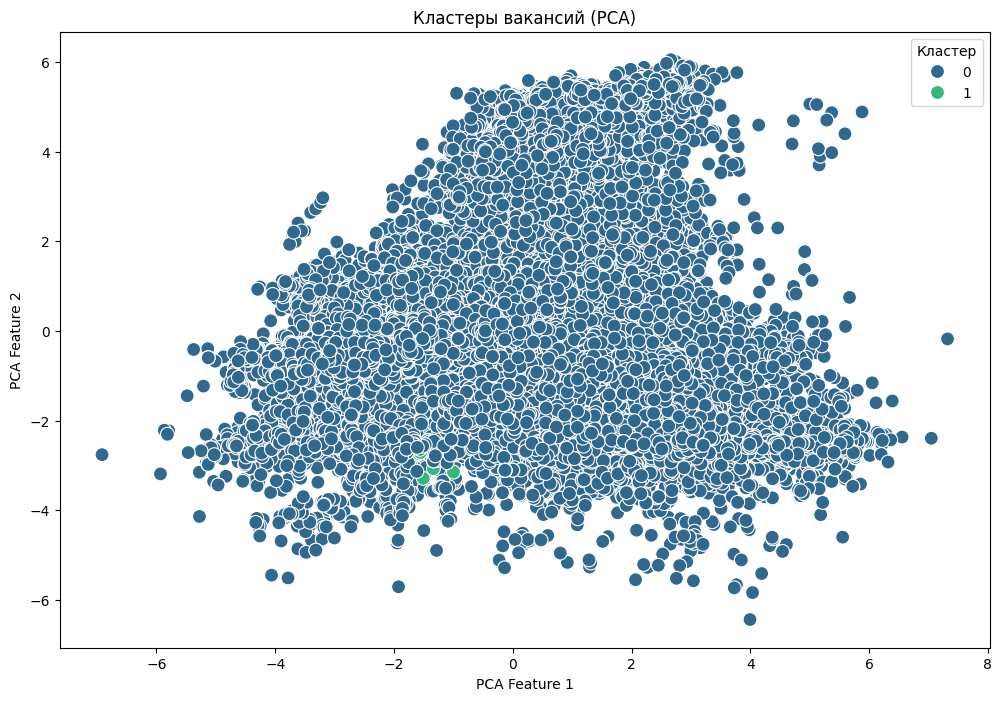

In [36]:
# Масштабирование числовых данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

# Кластеризация с помощью K-Means
kmeans = KMeans(n_clusters=2, random_state=42)  # Число кластеров можно подобрать
df["cluster"] = kmeans.fit_predict(scaled_data)

# PCA для визуализации
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Визуализация кластеров
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df["cluster"], palette="viridis", s=100)
plt.title("Кластеры вакансий (PCA)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend(title="Кластер")
plt.show()